This notebook tests the run_epoch, eval_network and train_network functions in tools.py, which cover exercises 2, 3 and 4.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torcheval.metrics

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns

import time
import os
import sys
sys.path.append('..')
from tools import *

assert(torch.cuda.is_available())
device = torch.device("cuda")

c:\Users\Miguel\miniconda3\envs\ml3\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


### Exercises 5 & 6

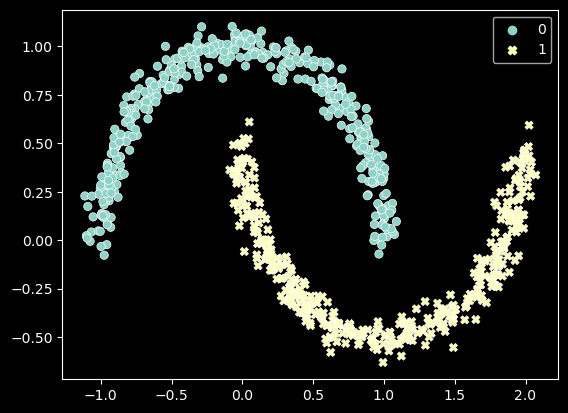

In [26]:
X, y = make_moons(n_samples=4000, noise=0.05)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
sns.scatterplot(x=X_test[:,0], y=X_test[:,1], hue=y_test, style=y_test)

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)

test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)

training_loader_32 = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
training_loader_1024 = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
testing_loader_32 = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

In [27]:
def build_model(n_hidden, n_neurons):
    layers = []
    layers.extend((nn.Linear(2, n_neurons), nn.Tanh()))
    for _ in range(0, n_hidden):
        layers.extend((nn.Linear(n_neurons, n_neurons), nn.Tanh()))
    layers.append(nn.Linear(n_neurons, 2))
    return nn.Sequential(*layers)

binary_accuracy_from_logits = from_logits(torcheval.metrics.functional.binary_accuracy)
binary_f1_from_logits = from_logits(torcheval.metrics.functional.binary_f1_score)

f_loss = torch.nn.functional.cross_entropy
metrics = {"Loss": f_loss, "Accuracy": binary_accuracy_from_logits, "F1 Score": binary_f1_from_logits}
eval_loaders = {"Train": training_loader_1024, "Test": testing_loader_32}

Epoch: 100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


    Last Epoch  Training Time  Train Loss  Train Accuracy  Train F1 Score  \
0            0       0.000000    0.693845        0.379375        0.400000   
1            1       0.145281    0.257990        0.883750        0.887409   
2            2       0.161659    0.235067        0.894375        0.895161   
3            3       0.139329    0.223593        0.899375        0.898806   
4            4       0.133677    0.195625        0.913437        0.913841   
5            5       0.133253    0.158730        0.927188        0.927482   
6            6       0.133851    0.119574        0.952500        0.953115   
7            7       0.135671    0.081669        0.971563        0.972060   
8            8       0.136219    0.053744        0.983750        0.983931   
9            9       0.134156    0.032886        0.997500        0.997502   
10          10       0.139482    0.022953        0.999375        0.999375   
11          11       0.137493    0.016189        0.999375        0.999375   

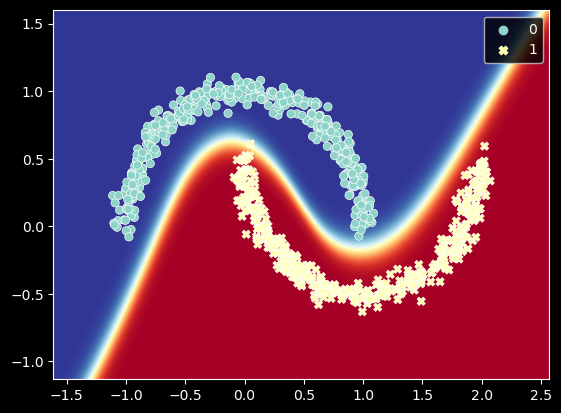

In [39]:
model = build_model(1, 50).to(device)
optimizer = torch.optim.AdamW(model.parameters())
# results = train_network( model, optimizer, f_loss, training_loader_1024,
#                         eval_loaders=eval_loaders, eval_metrics=metrics,
#                         epochs=20)
results = train_network( model, optimizer, f_loss, training_loader_32,
                        eval_loaders=eval_loaders, eval_metrics=metrics,
                        epochs=20)
print(results)
visualize_2D_classifier(X_test, y_test, model, resolution=200)

One hidden layer with 20 neurons is enough to classify everything correctly. Adding more neurons makes the boundary slightly sharper (although its overall shape remains roughly the same). This reduces the loss, improving the classification margin. 

Adding more layers not only makes the boundary sharper, but it also enables the boundary shape to more closely follow the curvature of the clusters. This reduces the loss and improves the classification margin even further. However, the improvement stops beyond a certain number of layers. At 20 hidden layers performance has clearly worsened, and classification is not even completely correct.

### Exercise 8

In [33]:
times = []
losses = []
log2_sizes = range(0, np.ceil(np.log2(len(train_dataset))).astype(int))
for p in log2_sizes:
    batch_size = 2**p
    print("Batch size: " + str(batch_size))
    loader_p = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    model = build_model(1, 50).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    results = train_network( model, optimizer, f_loss, loader_p,
                            eval_loaders=eval_loaders, eval_metrics=metrics, epochs=10)
    times.append(results.iloc[-1]["Training Time"])
    losses.append(results.iloc[-1]["Test Loss"])

Batch size: 1


Epoch: 100%|██████████| 10/10 [00:39<00:00,  3.99s/it]


Batch size: 2


Epoch: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


Batch size: 4


Epoch: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


Batch size: 8


Epoch: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Batch size: 16


Epoch: 100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Batch size: 32


Epoch: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


Batch size: 64


Epoch: 100%|██████████| 10/10 [00:01<00:00,  8.85it/s]


Batch size: 128


Epoch: 100%|██████████| 10/10 [00:00<00:00, 12.15it/s]


Batch size: 256


Epoch: 100%|██████████| 10/10 [00:00<00:00, 13.99it/s]


Batch size: 512


Epoch: 100%|██████████| 10/10 [00:00<00:00, 15.55it/s]


Batch size: 1024


Epoch: 100%|██████████| 10/10 [00:00<00:00, 14.81it/s]


Batch size: 2048


Epoch: 100%|██████████| 10/10 [00:00<00:00, 14.78it/s]


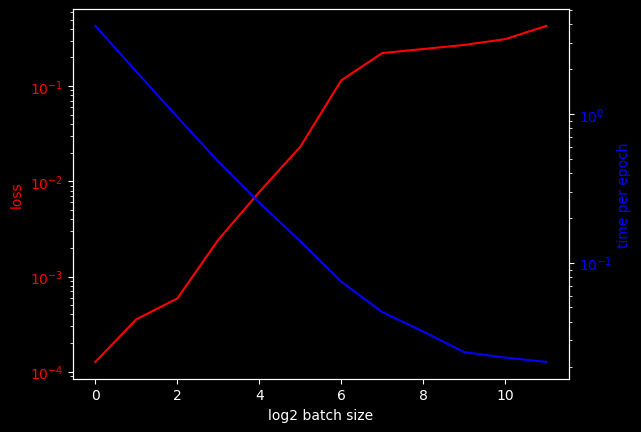

In [34]:
fig, ax_loss = plt.subplots()
ax_loss.set_xlabel('log2 batch size')
loss_color = "red"
line_loss = ax_loss.plot(log2_sizes, losses, color = loss_color, label = "loss")
ax_loss.set_ylabel('loss', color = loss_color)
ax_loss.tick_params(axis="y", labelcolor = loss_color)
ax_loss.set_yscale('log')

ax_time = ax_loss.twinx()
time_color = "blue"
line_time = ax_time.plot(log2_sizes, times, color = time_color, label = "time")
ax_time.set_ylabel('time per epoch', color = time_color)
ax_time.tick_params(axis="y", labelcolor = time_color)
ax_time.set_yscale('log')

For N_data and N_batch, we have ceil(N_data/N_batch) updates per epoch. For N_batch = N_data, we have one update per epoch and exact gradient descent. For N_batch = 1 we have N_data updates per epoch and pure stochastic gradient descent. Performance-wise, we can see that the N_train noisy updates in the latter are much better than the single exact update in the former. As we increase the batch size and reduce the updates per epoch, loss increases roughly at the same pace up to about a batch size of 32, at which it tapers off somewhat. In contrast, the training time per epoch steadily decreases with batch size up to about a size of 1024.

This suggests that it might be more efficient to increase the batch size as much as possible, even if this requires increasing the number of epochs in order to achieve the same loss, because the overall training time will be shorter.  However, there is another crucial factor to consider: training with larger batches (beyond 32) always yields worse final performance, no matter how many more epochs we train. The underlying reason is likely that the noise in the SGD updates reduces the chance of getting stuck in local minima. This noise is eliminated (or reduced altogether for exact GD) with batched updates. The noise also provides an implicit regularization mechanism.